In [8]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import numpy as np
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [6]:
#audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')
SAMPLESSIZE = 10
df = pd.read_csv('data.csv')
audio_ch1 = []
audio_ch2 = []
for i in df.ch1_file.sample(SAMPLESSIZE):
    x = tfio.audio.AudioIOTensor(i)
    x = tf.squeeze(x[:], axis=[-1])
    x = tf.cast(x, tf.float32) / 32768.0
    audio_ch1.append(x)

for i in df.ch2_file.sample(SAMPLESSIZE):
    x = tfio.audio.AudioIOTensor(i)
    x = tf.squeeze(x[:], axis=[-1])
    x = tf.cast(x, tf.float32) / 32768.0
    audio_ch2.append(x)
    
    #audio.append(tfio.audio.AudioIOTensor(i))
#print(audio_ch1)
print(audio_ch2)


[<tf.Tensor: shape=(44100,), dtype=float32, numpy=
array([-0.00421143, -0.00393677, -0.0038147 , ..., -0.006073  ,
       -0.00527954, -0.00469971], dtype=float32)>, <tf.Tensor: shape=(44100,), dtype=float32, numpy=
array([-0.00128174, -0.00115967, -0.00115967, ..., -0.0017395 ,
       -0.00161743, -0.00140381], dtype=float32)>, <tf.Tensor: shape=(44100,), dtype=float32, numpy=
array([-0.00292969, -0.00442505, -0.00540161, ..., -0.00042725,
       -0.00067139, -0.0015564 ], dtype=float32)>, <tf.Tensor: shape=(44100,), dtype=float32, numpy=
array([-0.00305176, -0.00314331, -0.00317383, ..., -0.00305176,
       -0.00302124, -0.00308228], dtype=float32)>, <tf.Tensor: shape=(44100,), dtype=float32, numpy=
array([-0.0007019 , -0.00067139, -0.00061035, ..., -0.0007019 ,
       -0.0007019 , -0.00067139], dtype=float32)>, <tf.Tensor: shape=(44100,), dtype=float32, numpy=
array([-0.00015259, -0.00048828, -0.0010376 , ..., -0.00149536,
       -0.00061035, -0.00015259], dtype=float32)>, <tf.Tenso

In [32]:

SAMPLESSIZE = 11
audio_ch1_list = []
audio_ch2_list = []
for index, row in df[:SAMPLESSIZE].iterrows():
    print(row['ch1_file'], row['ch2_file'])
    x1 = tfio.audio.AudioIOTensor(row['ch1_file'])
    x1 = tf.squeeze(x1[:], axis=[-1])
    x1 = tf.cast(x1, tf.float32) / 32768.0

    for i in tf.split(x1,10):
        print('split1')
        audio_ch1_list.append(i)

    x = tfio.audio.AudioIOTensor(row['ch2_file'])
    x = tf.squeeze(x[:], axis=[-1])
    x = tf.cast(x, tf.float32) / 32768.0
    for i in tf.split(x,10):
        print('split2')
        audio_ch2_list.append(i)

print(audio_ch1_list)

soundfiles//ch1//0_0_1000.wav soundfiles//ch2//0_0_1000.wav
split1
split1
split1
split1
split1
split1
split1
split1
split1
split1
split2
split2
split2
split2
split2
split2
split2
split2
split2
split2
soundfiles//ch1//1_0_1000.wav soundfiles//ch2//1_0_1000.wav
split1
split1
split1
split1
split1
split1
split1
split1
split1
split1
split2
split2
split2
split2
split2
split2
split2
split2
split2
split2
soundfiles//ch1//2_0_1000.wav soundfiles//ch2//2_0_1000.wav
split1
split1
split1
split1
split1
split1
split1
split1
split1
split1
split2
split2
split2
split2
split2
split2
split2
split2
split2
split2
soundfiles//ch1//3_0_1000.wav soundfiles//ch2//3_0_1000.wav
split1
split1
split1
split1
split1
split1
split1
split1
split1
split1
split2
split2
split2
split2
split2
split2
split2
split2
split2
split2
soundfiles//ch1//4_0_1000.wav soundfiles//ch2//4_0_1000.wav
split1
split1
split1
split1
split1
split1
split1
split1
split1
split1
split2
split2
split2
split2
split2
split2
split2
split2
split2
split2


In [41]:
def get_spectrogram(waveform):
      # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = waveform #tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=1, frame_step=1)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [4]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

NameError: name 'audio_tensor' is not defined

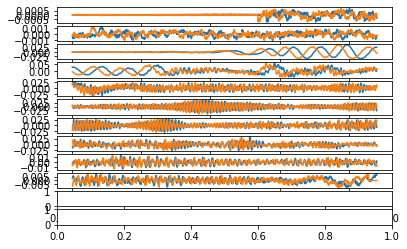

In [73]:
import matplotlib.pyplot as plt
#plt.figure()
n_plot = 12
figure, axis = plt.subplots(n_plot)

acc = 0
for i in audio_ch1_list[:10]:
    axis[acc].plot(i[:44000].numpy())
    blah = i
    acc += 1

acc = 0
for i in audio_ch2_list[:10]:
    axis[acc].plot(i[:44000].numpy())
    blah = i
    acc += 1

In [74]:
#this might crash your PC
SAMPLESSIZE = 10
df = pd.read_csv('data.csv')

audio_ch1_list = []
audio_ch2_list = []
acc = 0 
for index, row in df.iterrows():
    if os.path.exists('C://sound//spectrograms//soundfiles_grayscale_small//{}.jpg'.format(row['ch1_file'].replace('.wav', ''))) is not True:
        x1 = tfio.audio.AudioIOTensor(row['ch1_file'])
        x1 = tf.squeeze(x1[:], axis=[-1])
        x1 = tf.cast(x1, tf.float32) / 32768.0

        acc = 0 
        for i in tf.split(x1,10)[:1]:
            audio_ch1_list.append(i)
            spectrogram = get_spectrogram(i)
            fig = plt.figure()
            plt.axis('off')
            plt.imshow(tf.math.log(spectrogram).numpy(),interpolation='nearest', cmap='gray')
            fig.savefig('C://sound//spectrograms//soundfiles_greyscale_small//{}split_{}.jpg'.format(row['ch1_file'].replace('.wav', ''),str(acc)),bbox_inches='tight')
            acc += 1
            #print(row['ch1_file'], row['ch2_file'])


        #audio_ch1_list.append(x1)
        x = tfio.audio.AudioIOTensor(row['ch2_file'])
        x = tf.squeeze(x[:], axis=[-1])
        x = tf.cast(x, tf.float32) / 32768.0

        acc = 0
        for i in tf.split(x,10)[:1]:
            audio_ch2_list.append(i)
            spectrogram2 = get_spectrogram(i)
            #print(spectrogram)
            fig = plt.figure()
            plt.axis('off')
            plt.imshow(tf.math.log(spectrogram2).numpy(),cmap='gray')        
           
            fig.savefig('C://sound//spectrograms//soundfiles_greyscale_small//{}split_{}.jpg'.format(row['ch2_file'].replace('.wav', ''),str(acc)),bbox_inches='tight')
            acc += 1


C:\Users\Leona\AppData\Local\Temp/ipykernel_28764/4169571465.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


tf.Tensor(
[[[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]], shape=(231, 81, 3), dtype=uint8)


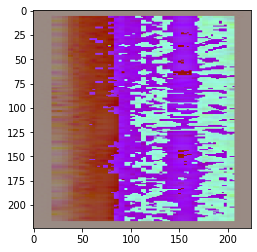

In [72]:
x = tf.io.read_file('C:\\sound\\spectrograms\\soundfiles_greyscale_small\\soundfiles\ch2\\0_0_1000split_3.jpg')
x = tf.image.decode_jpeg(x)

x1 = tf.io.read_file('C:\\sound\\spectrograms\\soundfiles_greyscale_small\\soundfiles\ch1\\0_0_1000split_3.jpg')
x1 = tf.image.decode_jpeg(x1)
#plt.imshow(x)
print(x)
zez = tf.zeros(shape=(231, 81, 1))
zez =tf.cast(zez, tf.uint8)

reshape_vgg19 = tf.keras.applications.vgg19.preprocess_input(tf.concat([x1[:,:,:1],x[:,:,:1] ,zez],axis=2), data_format=None)
plt.imshow(tf.image.resize(reshape_vgg19, [224, 224],method='nearest'),cmap='gray')


In [ ]:



for i in audio:
    #print(x)
    #spectrogram= tfio.audio.spectrogram(i, nfft=512, window=512, stride=512)
   #spectrogram = tf.signal.stft(i,512,512,fft_length = 44100)
   #spectrogram = tf.abs(spectrogram)
   #plt.figure()
   #plt.imshow(time_mask.numpy())
   spectrogram = get_spectrogram(i)
   print(spectrogram)
   fig = plt.figure()
   plt.imshow(tf.math.log(spectrogram).numpy())
   fig.savefig('C:\\sound\\spectrograms\\spec.png')
#time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)




In [3]:
'''def new_csv(_filedir):
    for file in os.listdir(_filedir):
            try:
                #raw = wave.open(_filedir + file)
                #signal = raw.readframes(-1)
                #signal = np.frombuffer(signal, dtype ="int16")
                
                #for ind in range(_number_of_shifts_per_instance):
                    #shift,angle = _pg.genRandEe()
                    # shift file save copy
                    #ch2 = np.roll(signal,shift=shift)
                    print(file,shift,signal)

                    d['ch1_file'].append(str(_filedir+ ch1dir + str(ind) + "_" + file))
                    d['ch2_file'].append(str(_filedir+ ch2dir + str(ind) + "_" + file))
                    d['angle'].append(angle)
                    d['shift'].append(shift)
                    print(_filedir + ch1dir + str(ind)+ "_" + file)
                    write(str(_filedir+ ch1dir + str(ind) + "_" + file), SAMPLERATE, signal)
                    write(str(_filedir+ ch2dir + str(ind) + "_" + file), SAMPLERATE, ch2)
                    
            except:
                print(file + "did not shift correctly")
            # split into ch1 dir and ch2 dir
        df = pd.DataFrame(data=d)
        df.to_csv(DATACSVPATH)'''

#read ch1 files
ch1_spec_dir = 'C:\sound\spectrograms\soundfiles_grayscale\soundfiles\ch1'
ch2_spec_dir = 'C:\sound\spectrograms\soundfiles_grayscale\soundfiles\ch2'
ch1_spec_files = []
ch2_spec_files = []

for file in os.listdir(ch1_spec_dir):
    ch1_spec_files.append(ch1_spec_dir+'\\'+file)

for file in os.listdir(ch2_spec_dir):
    ch2_spec_files.append(ch2_spec_dir+ '\\' + file)
print(ch1_spec_files[0])
print(ch2_spec_files[0])



C:\sound\spectrograms\soundfiles_grayscale\soundfiles\ch1\0_0_1000.jpg
C:\sound\spectrograms\soundfiles_grayscale\soundfiles\ch2\0_0_1000.jpg


In [6]:
df = pd.read_csv('spec_data.csv')
new_df = df
new_df['spec_gray_ch1_files'] =  ch1_spec_files
new_df['spec_gray_ch2_files'] =  ch2_spec_files

In [7]:
new_df.head()
df.to_csv('spec_data.csv')

(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)
(288, 432, 4)
(288, 864, 4)


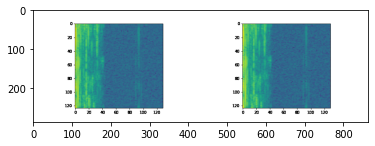

In [30]:
df = pd.read_csv('spec_data.csv')
for index, row in df.iterrows():
    x = tf.io.read_file(row['spec_ch1_files'])
    x = tf.image.decode_image(x)
    print(x.shape)
    #test_img = tf.image.resize(x, [192, 192])
    x2 = tf.io.read_file(row['spec_ch2_files'])
    x2 = tf.image.decode_image(x2)
    #test_img2 = tf.image.resize(x2, [192, 192])

    stackedImg = np.concatenate((x, x2), axis=1)
    print(stackedImg.shape)
    plt.imshow(stackedImg)
